![AI Gender Bias](./gender_bias.png)


# Semantic Embedding and Distances using Transformers: Assessing Gender Consistency in Directional and Magnitudinal Embedding Spaces

## Introduction

In the rapidly advancing field of Natural Language Processing (NLP), semantic embeddings have emerged as a cornerstone for a multitude of applications, enabling machines to grasp complex human language nuances. These embeddings, which translate words into high-dimensional vectors, are pivotal for assessing semantic similarity—how closely the meanings of words relate to each other within a given linguistic context. A particularly intriguing area of study within semantic embeddings is the exploration of how gender dimensions are represented and whether there is an inherent bias in these representations.

This research delves into the gendered landscape of semantic embeddings, focusing on the hypothesis that the gender opposition of the same concept is reflected in a consistent pattern within the vector space. By comparing word pairs that signify the same concept but differ in gender - such as "waitress" vs. "waiter" or "actor" vs. "actress" — this study examines both the directional and magnitudinal similarities in their respective word vectors. The consistency of these dimensions could unveil systematic patterns in how gendered language is encoded within word embeddings, potentially shedding light on latent biases. [Previous studies](https://arxiv.org/pdf/2206.03390.pdf#:~:text=Specifically%2C%20of%20the%20top%201%2C000,55%25%20are%20associated%20with%20men.) have explored aspects of gender bias in semantic embeddings, providing a foundation upon which this research builds. The goal is to offer a deeper understanding of gender representation in semantic spaces, contributing to the ongoing conversation on fairness and equality in AI models.

## Research Question

The investigation at the heart of this study is encapsulated in the research question: How consistent are the directional and magnitudinal differences between word embeddings for gender-specific pairs across various semantic concepts? This question seeks to quantitatively unravel the gender dimensions encoded within word embeddings, focusing specifically on whether the embedded vectors of gender-opposite words representing the same concept exhibit a standard distance and orientation in the semantic vector space.

To elucidate this further, the research examines the extent to which the semantic similarity (or rather, dissimilarity), as captured by cosine and Euclidean distances, between male and female word pairs such as "actor" and "actress" or "king" and "queen", remains constant across different concepts. The analysis of this consistency could provide pivotal insights into the structural biases of word embeddings and their implications for gender representation in automated language processing. The exploration is grounded in the hypothesis that the gender difference of a concept is represented by roughly equivalent distances in the embedding space, implying a uniformity in how NLP models process gendered language. 

## Data Overview

- **Dataset Source and Credibility**: Utilizes a [licensed dataset from WordNet](https://github.com/ecmonsen/gendered_words/tree/master), ensuring high credibility and reliability for the linguistic data foundational to the study.
  
- **Dataset Composition**:
  - **Total Words**: Comprises 6,923 words, each carefully annotated with gender designations:
    - 'f' for female
    - 'm' for male
    - 'n' for gender-neutral
  - These designations reflect the natural gender of the person or type of person to which the word refers.

- **Additional Features**:
  - **Gender Map Column**: Includes a 'gender_map' column that links words to others of different genders, facilitating deeper exploration of gender-based linguistic relationships.
  - **Wordnet Senseno**: Although the dataset includes a 'wordnet_senseno' column for referencing additional lexical information from WordNet, this detail will not be used in the analysis.

- **Data Processing and Analysis Focus**:
  - **Data Conversion**: Plans to convert the JSON file format into a tabular format using pandas DataFrames.
  - **Analysis Focus**: Emphasizes the analysis on the 'word' and 'gender' columns, aiming for a nuanced examination of gender representation across the dataset.

## Data Preperation

Importing necessary libraries and loading the dataset into a pandas DataFrame for further analysis.

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Specify the file path
file_path = "./gendered_words.json"

# Read the JSON file into a DataFrame
df = pd.read_json(file_path)

# Display the DataFrame
df


,word,wordnet_senseno,gender,gender_map
0,abandoned_person,abandoned_person.n.01,n,NaN
1,abator,abator.n.01,n,NaN
2,abbe,abbe.n.01,n,NaN
3,abbess,abbess.n.01,f,"{'m': [{'parts_of_speech': '*', 'word': 'abbot..."
4,abbot,abbot.n.01,m,NaN
...,...,...,...,...
6918,zoo_keeper,zoo_keeper.n.01,n,NaN
6919,zoologist,zoologist.n.01,n,NaN
6920,zoroastrian,zoroastrian.n.01,n,NaN
6921,zulu,zulu.n.01,n,NaN


Further extract columns from the gender_map column: alt_word and alt_gender. This essentially matches words with their opposite gender counterparts, providing a foundation for the subsequent analysis

In [12]:
df = df.dropna(subset=['gender_map'])
def extract_info(row):
    for gender, details in row.items():
        return pd.Series({
            'alt_gender': gender,
            'alt_word': details[0]['word']
        })
expanded_data = df['gender_map'].apply(extract_info)
df = df.join(expanded_data)

df.drop_duplicates(subset='word', inplace=True) # dropping duplicates
df.reset_index(drop=True, inplace=True)
df.drop(columns=['gender_map', 'wordnet_senseno'], inplace=True)

df

,word,gender,alt_gender,alt_word
0,abbess,f,m,abbot
1,able_seaman,m,f,able_seawoman
2,actress,f,m,actor
3,adulteress,f,m,adulterer
4,adventuress,f,m,adventurer
...,...,...,...,...
499,yachtsman,m,f,yachtswoman
500,yardman,m,f,yardwoman
501,yellow_man,m,f,yellow_woman
502,yellow_woman,f,m,yellow_man


Further reducing duplicates in the dataset by removing rows where the word is the same as the alt_word. This step ensures that the subsequent nlp word vectorization, which is a computationally intensive process, is not redundant.

In [13]:
df = df[~df['word'].isin(df['alt_word'])]
df = df.reindex(columns=['word', 'gender', 'alt_word', 'alt_gender']).reset_index(drop=True)
df

,word,gender,alt_word,alt_gender
0,abbess,f,abbot,m
1,able_seaman,m,able_seawoman,f
2,actress,f,actor,m
3,adulteress,f,adulterer,m
4,adventuress,f,adventurer,m
...,...,...,...,...
355,working_girl,f,working_boy,m
356,workman,m,workwoman,f
357,yachtsman,m,yachtswoman,f
358,yardman,m,yardwoman,f


Check if every word has a corresponding alt_word with the opposite gender. 

In [14]:
check = (df['gender'] == 'f') & (df['alt_gender'] == 'm') | (df['gender'] == 'm') & (df['alt_gender'] == 'f')
check.all()

True

Demonstratino of Spacy (Non-transformer) word vectorization capabilities against a transformer-based model

In [15]:
import spacy
import spacy.cli

# Ensure that model isn't installed repeatedly
try:
    # Try to load the model to see if it's already installed
    nlp = spacy.load("en_core_web_lg")
    print("Model is successfully loaded.")
except OSError:
    # If the model is not installed, download it
    print("Model not found. Downloading now...")
    spacy.cli.download("en_core_web_lg")
    print("Model is successfully loaded.")

Model is successfully loaded.


In [16]:
df_spacy = df.copy()
df_spacy['word_vector'] = df_spacy['word'].apply(lambda x: nlp(x).vector)
df_spacy['alt_word_vector'] = df_spacy['alt_word'].apply(lambda x: nlp(x).vector)
df_spacy

,word,gender,alt_word,alt_gender,word_vector,alt_word_vector
0,abbess,f,abbot,m,"[-0.055308, -4.1129, 0.13099, -0.66051, -0.074...","[-2.4365, -5.7415, -0.18164, 0.86196, 0.56676,..."
1,able_seaman,m,able_seawoman,f,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,actress,f,actor,m,"[-0.19423, 1.952, -1.9048, -4.79, -0.63103, 0....","[-2.2196, 0.825, -1.2274, -3.7514, -0.51313, 1..."
3,adulteress,f,adulterer,m,"[0.15472, -0.64138, -1.5163, -1.8773, 0.92957,...","[-0.8278, -1.0626, -0.70223, -1.6146, 1.5188, ..."
4,adventuress,f,adventurer,m,"[-0.70933, 0.13014, 0.046859, -3.7926, -0.8595...","[-0.05648, -0.19939, 1.4233, -4.7611, -1.5092,..."
...,...,...,...,...,...,...
355,working_girl,f,working_boy,m,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
356,workman,m,workwoman,f,"[-2.3501, -1.2634, -1.299, -1.1481, 1.0886, -2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
357,yachtsman,m,yachtswoman,f,"[-1.479, -0.47629, 1.3346, -1.8885, -0.28168, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
358,yardman,m,yardwoman,f,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Count the number of rows where df['word_vector'] or df['alt_word_vector'] has zero vectors

In [17]:
num_zero_vectors = ((df_spacy['word_vector'].apply(lambda x: sum(x)) == 0) | (df_spacy['alt_word_vector'].apply(lambda x: sum(x)) == 0)).sum()
print("Number of rows with zero vectors:", num_zero_vectors)

Number of rows with zero vectors: 253


Initializing transformer model

In [18]:
from transformers import BertModel, BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [19]:
inputs = tokenizer("abbess", return_tensors="pt")
outputs = model(**inputs)
embedding = outputs.last_hidden_state
print(embedding)
print(embedding.shape)

tensor([[[-0.1592,  0.1311,  0.0150,  ..., -0.0561,  0.1057,  0.0700],
         [-0.6742, -0.4687, -0.1025,  ..., -0.1672,  0.3564, -0.0935],
         [ 0.9349,  0.1159, -0.2163,  ..., -0.0172, -0.8653, -0.5190]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 3, 768])


The word embeddings are then extracted from the transformer model, providing a high-dimensional representation of the words in the dataset. These embeddings are pivotal for the subsequent analysis. Here, the word "abbess" is represented by 3 tokens (BERT starts with a [CLS] token and ends with a [SEP] token), each with a 768-dimensional vector.

Vectorizing the gendered word pairs

In [20]:
import torch
# Function to get the vector for a word using BERT's last hidden state
def get_word_vector(word):
    # Tokenize the word and convert to tensor
    inputs = tokenizer(word, return_tensors="pt")
    # Get the model's output
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)
    # Get the last hidden state
    last_hidden_state = outputs.last_hidden_state
    # We take the mean of the last hidden state to represent the word vector
    word_vector = last_hidden_state.mean(dim=1).squeeze().numpy()
    return word_vector

# Apply the function to each word in the 'word' and 'alt_word' columns
df['word_vector'] = df['word'].apply(get_word_vector)
df['alt_word_vector'] = df['alt_word'].apply(get_word_vector)

In [21]:
df.head()

,word,gender,alt_word,alt_gender,word_vector,alt_word_vector
0,abbess,f,abbot,m,"[0.03386249, -0.073890425, -0.10126286, -0.018...","[-0.077743076, -0.047490407, -0.25444508, 0.09..."
1,able_seaman,m,able_seawoman,f,"[-0.03936876, -0.09774977, 0.19937399, 0.09556...","[0.12963812, -0.35763657, 0.23135026, 0.238661..."
2,actress,f,actor,m,"[0.25073627, -0.0036050454, -0.24463184, -0.15...","[0.18325412, 0.16643943, -0.5841664, -0.180490..."
3,adulteress,f,adulterer,m,"[0.109185375, 0.03621303, -0.68881613, -0.0334...","[-0.33493897, -0.40118265, -0.23603559, -0.325..."
4,adventuress,f,adventurer,m,"[-0.20856036, -0.3213589, -0.19327125, -0.1711...","[0.20072049, -0.028415183, -0.11743646, 0.0113..."


In [28]:
num_zero_vectors = ((df['word_vector'].apply(lambda x: sum(x)) == 0) | (df['alt_word_vector'].apply(lambda x: sum(x)) == 0)).sum()
print("Number of rows with zero vectors:", num_zero_vectors)

Number of rows with zero vectors: 0


Calculating the cosine and Euclidean distances between the word embeddings of the words

In [22]:
from scipy.spatial.distance import cosine, euclidean

# Function to calculate semantic distances
def calculate_distances(row):
    word_vector = row['word_vector']
    alt_word_vector = row['alt_word_vector']
    
    # Calculate cosine distance (1 - cosine similarity)
    cosine_dist = cosine(word_vector, alt_word_vector)
    
    # Calculate Euclidean distance
    euclidean_dist = euclidean(word_vector, alt_word_vector)
    
    return pd.Series([cosine_dist, euclidean_dist], index=['cosine_distance', 'euclidean_distance'])

# Apply the function to each row in the dataframe
df[['cosine_distance', 'euclidean_distance']] = df.apply(calculate_distances, axis=1)

df.head(5)


,word,gender,alt_word,alt_gender,word_vector,alt_word_vector,cosine_distance,euclidean_distance
0,abbess,f,abbot,m,"[0.03386249, -0.073890425, -0.10126286, -0.018...","[-0.077743076, -0.047490407, -0.25444508, 0.09...",0.099397,3.892932
1,able_seaman,m,able_seawoman,f,"[-0.03936876, -0.09774977, 0.19937399, 0.09556...","[0.12963812, -0.35763657, 0.23135026, 0.238661...",0.158315,4.971286
2,actress,f,actor,m,"[0.25073627, -0.0036050454, -0.24463184, -0.15...","[0.18325412, 0.16643943, -0.5841664, -0.180490...",0.032879,2.622550
3,adulteress,f,adulterer,m,"[0.109185375, 0.03621303, -0.68881613, -0.0334...","[-0.33493897, -0.40118265, -0.23603559, -0.325...",0.239453,6.754234
4,adventuress,f,adventurer,m,"[-0.20856036, -0.3213589, -0.19327125, -0.1711...","[0.20072049, -0.028415183, -0.11743646, 0.0113...",0.221328,5.865451


With that, the dataframe is now ready for analysis, with the words fully paired with their gender opposites and the cosine and Euclidean distances calculated for each pair. This cleanup process left us with 107 pairs of gender-opposite word pairs to work with for our analysis. 

## Statistical Analysis

First, we will examine the distribution of cosine distances

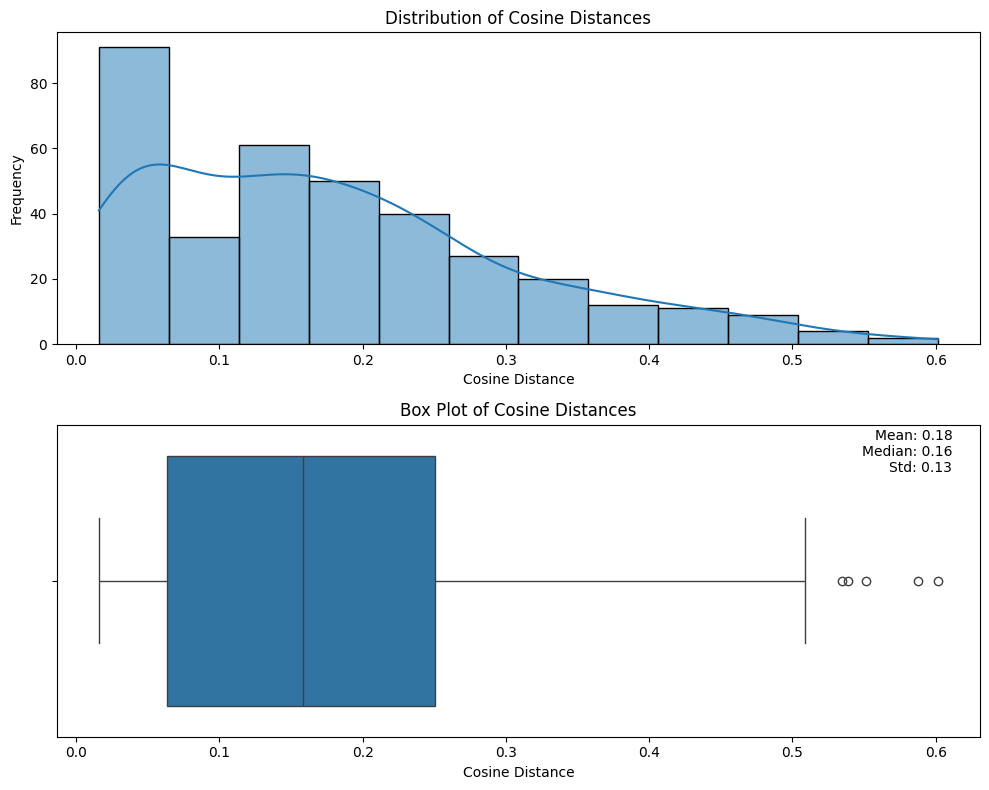

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Subplot 1: Histogram
sns.histplot(df['cosine_distance'], kde=True, ax=ax1)
ax1.set_title('Distribution of Cosine Distances')
ax1.set_xlabel('Cosine Distance')
ax1.set_ylabel('Frequency')

# Subplot 2: Box plot
sns.boxplot(x=df['cosine_distance'], ax=ax2)
ax2.set_title('Box Plot of Cosine Distances')
ax2.set_xlabel('Cosine Distance')

# Calculate mean, median, and std
mean = df['cosine_distance'].mean()
median = df['cosine_distance'].median()
std = df['cosine_distance'].std()

# Position the annotations on the plot. Adjust the y-coordinates as needed.
ax2.text(0.97, 0.95, f'Mean: {mean:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.90, f'Median: {median:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.85, f'Std: {std:.2f}', transform=ax2.transAxes, ha='right')

plt.tight_layout()
plt.show()

**Metric Explanation**: 

Cosine distance, calculated as 1−cosine similarity, ranges from 0 to 2. A cosine distance of 0 means the vectors are perfectly aligned (identical), and a distance of 2 indicates they are exactly opposite. The observed range suggests minimal angular differences between the vectors.

Similarly, we will examine the distribution of distances

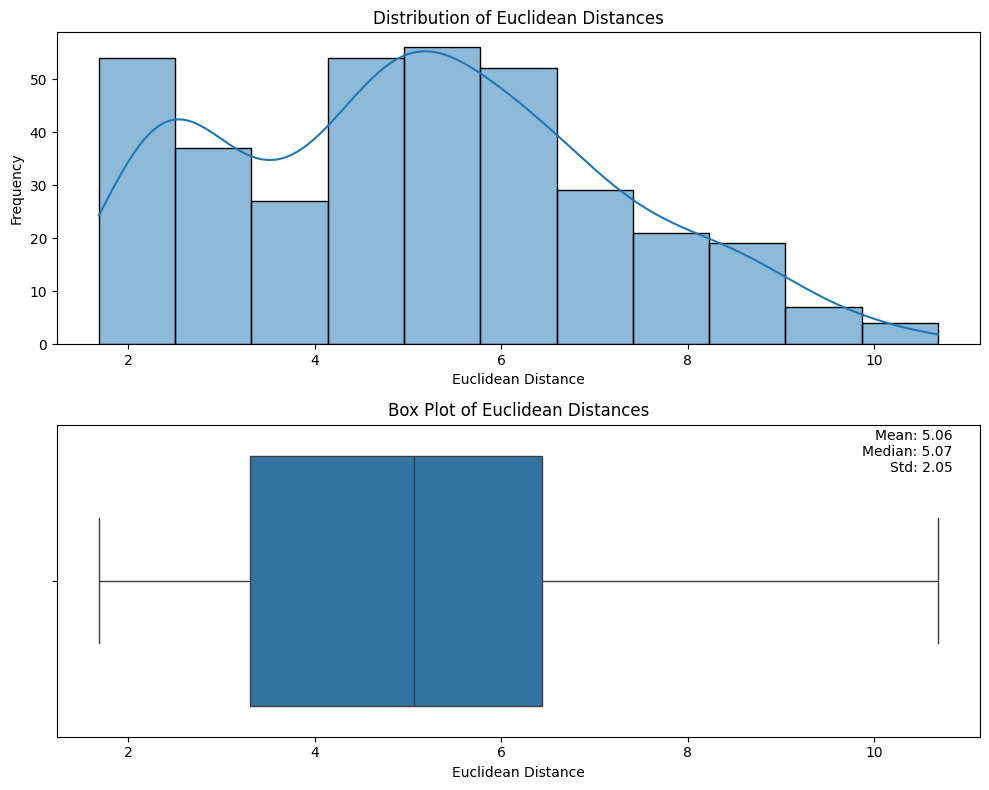

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Subplot 1: Histogram
sns.histplot(df['euclidean_distance'], kde=True, ax=ax1)
ax1.set_title('Distribution of Euclidean Distances')
ax1.set_xlabel('Euclidean Distance')
ax1.set_ylabel('Frequency')

# Subplot 2: Box plot
sns.boxplot(x=df['euclidean_distance'], ax=ax2)
ax2.set_title('Box Plot of Euclidean Distances')
ax2.set_xlabel('Euclidean Distance')

# Calculate mean, median, and std
mean = df['euclidean_distance'].mean()
median = df['euclidean_distance'].median()
std = df['euclidean_distance'].std()

# Position the annotations on the plot. Adjust the y-coordinates as needed.
ax2.text(0.97, 0.95, f'Mean: {mean:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.90, f'Median: {median:.2f}', transform=ax2.transAxes, ha='right')
ax2.text(0.97, 0.85, f'Std: {std:.2f}', transform=ax2.transAxes, ha='right')

plt.tight_layout()
plt.show()


**Metric Explanation**: 

Euclidean distance measures the "straight-line" distance between vectors in the embedding space, with values that can theoretically extend from 0 to infinity. The specific interval observed here underlines a controlled variability.

### Normality Test of the Distance Distributions

In [25]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for euclidean_distance
statistic_euclidean, p_value_euclidean = shapiro(df['euclidean_distance'])

# Print the test statistic and p-value for euclidean_distance
print("Shapiro-Wilk Test Statistic(W) for Euclidean Distance:", statistic_euclidean)
print("p-value for Euclidean Distance:", p_value_euclidean)

# Perform Shapiro-Wilk test for cosine_distance
statistic_cosine, p_value_cosine = shapiro(df['cosine_distance'])

# Print the test statistic and p-value for cosine_distance
print("Shapiro-Wilk Test Statistic(W) for Cosine Distance:", statistic_cosine)
print("p-value for Cosine Distance:", p_value_cosine)

Shapiro-Wilk Test Statistic(W) for Euclidean Distance: 0.9695868222905087
p-value for Euclidean Distance: 7.603798909120064e-07
Shapiro-Wilk Test Statistic(W) for Cosine Distance: 0.9233715068574464
p-value for Cosine Distance: 1.3117954498545846e-12


- **Results**:
  - **Euclidean Distance**:
    - **Statistic (W)**: 0.9696
    - **P-value**: Extremely small, close to 0
  - **Cosine Distance**:
    - **Statistic (W)**: 0.9234
    - **P-value**: Even smaller than that for Euclidean distance

- **Interpretation**:
  - **Deviation from Normality**: Both sets of distances significantly deviate from a normal distribution.
  - **Statistical Significance**: P-values are well below the conventional alpha threshold of 0.05, providing strong evidence to reject the null hypothesis of normal distribution.

- **Implications**:
  - **Need for Non-Parametric Methods**: The findings necessitate the use of non-parametric statistical techniques that do not assume normal distribution in subsequent analyses due to the non-normality of the data.

### Methodology: Bootstrap Resampling

- **Choice of Method**: Bootstrap resampling was selected to test the hypothesis, valued for its ability to elucidate complex confidence intervals for mean cosine and Euclidean distances.

- **Purpose**:
  - **Insights**: Provides insights into whether there is a consistent pattern in the directional and magnitude differences between word embeddings.
  
- **Interpretation of Results**:
  - **Smaller Confidence Intervals**: Indicate a higher level of consistency in the distances between gender-opposite word pairs representing the same concept.
  - **Larger Confidence Intervals**: Suggest less consistency in these distances.

In [26]:
# Define the number of bootstrap samples to draw
n_bootstraps = 10000

# Function to draw bootstrap samples and calculate the mean of the distances
def bootstrap_mean(sample, n_bootstraps):
    boot_means = []
    for _ in range(n_bootstraps):
        # Sample with replacement from the given sample
        boot_sample = np.random.choice(sample, size=len(sample), replace=True)
        # Calculate the mean of this bootstrap sample
        boot_means.append(np.mean(boot_sample))
    return boot_means

# Bootstrap for cosine distance
cosine_means = bootstrap_mean(df['cosine_distance'], n_bootstraps)

# Bootstrap for Euclidean distance
euclidean_means = bootstrap_mean(df['euclidean_distance'], n_bootstraps)

# Calculate the 95% confidence intervals for each distribution of bootstrap means
cosine_conf_int = np.percentile(cosine_means, [2.5, 97.5])
euclidean_conf_int = np.percentile(euclidean_means, [2.5, 97.5])

# Output the results
print("95% confidence interval for the mean cosine distance:", cosine_conf_int)
print("95% confidence interval for the mean Euclidean distance:", euclidean_conf_int)


95% confidence interval for the mean cosine distance: [0.16636836 0.19279751]
95% confidence interval for the mean Euclidean distance: [4.85228783 5.279827  ]


- **Bootstrap Methodology**: This approach is leveraged for its advantage of not assuming an underlying distribution of data, which is critical for generating reliable 95% confidence intervals for the distance metrics used in this study.

- **Cosine Distance Analysis**:
  - **Range**: 0.166 to 0.193, indicating a narrow confidence interval.
  - **Implication**: Demonstrates a high level of uniformity in the directional relationships between word pairs representing the same concept but different genders, underpinning the consistent directional patterns in gender representation within word embeddings.
  - **Supports Hypothesis**: Strengthens the hypothesis that linguistic representations of gender exhibit consistent directional consistencies across different contexts.

- **Euclidean Distance Analysis**:
  - **Range**: 4.848 to 5.275, showing notable consistency in the magnitude of differences.
  - **Implication**: Indicates a stable degree of variability in how gender is represented across different concepts, suggesting that the magnitudes of differences between vectors of gendered word pairs are not only consistent but also confined within a predictable range.
  - **Context**: This metric's behavior in the observed interval highlights its effectiveness in capturing the magnitude of the differences without being influenced by the directionality, as opposed to cosine distance.

- **Conclusion**:
  - **Summary of Findings**: The computed confidence intervals for both cosine and Euclidean distances confirm that there is a stable and consistent pattern in how genders are represented in word embeddings, evident in both directional alignment and magnitude of differences.
  - **Further Significance**: These results underscore the systematic nature of gender representation within language model embeddings, suggesting the need for further investigation into their implications for natural language understanding and generation, especially considering the nuanced ways genders are differentiated linguistically.


----

## Limitations and Future Directions

### Arbitrary Nature of "Small Enough" Intervals
While the confidence intervals suggest consistency, the criteria for what constitutes a "small enough" interval to denote true consistency remain arbitrary. This introduces a limitation in the conclusiveness of our results. To address this, future analyses could compare these intervals against those obtained from word pairs exhibiting semantic differences beyond gender, as well as from words unrelated to gender. Establishing such a baseline or control group would provide a clearer standard for what "consistency" entails within the context of semantic embeddings.

### Semantic Analysis Through Contextual Transformers
Further, the study extends its analysis by utilizing the advanced capabilities of transformers to manipulate and analyze sentences where only the gendered terms are swapped. This approach leverages the contextual sensitivity of transformer models to assess how swapping gendered terms in sentences or paragraphs affects the semantic structure. By generating content based on diverse literature materials such as short stories or news articles, we can delve deeper into the nuanced differences brought about by gendered language.

### Expanding the Gender Pair Dataset
To broaden the scope of this study, there is a compelling case for expanding the gender pair dataset to include gender-neutral variants of the same concepts. For example, incorporating terms like 'monarch' alongside 'king' and 'queen' would allow an exploration into not only the semantic differences between male and female terms but also those pertaining to gender-neutral terms. Such an expansion would enrich our understanding of gender representation across a wider spectrum of linguistic contexts, potentially uncovering more complex patterns of gender semantics in language models.

---

## Conclusion

This project has illuminated significant aspects of gender representation in semantic embeddings, providing a foundational analysis that underscores the consistency of gender portrayals across different word pairs. By applying advanced analytical methods such as bootstrap subsampling and leveraging the capabilities of transformer models, we have paved the way for a broader initiative aimed at studying and safeguarding against gender biases in the further development of AI models. Our findings highlight the potential for these technologies to either perpetuate or mitigate biases, underscoring the importance of continued vigilance and proactive measures in AI research. This study not only contributes to our understanding of gender semantics in language models but also sets the stage for more comprehensive efforts to ensure that AI advancements are equitable and inclusive. 